In [11]:
from pathlib import Path
import os
import logging
from io import StringIO
import pprint
from pprint import pformat
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dynamic_yaml
import yaml
import wfdb

with open('../config/data_config.yaml') as f:
    data = dynamic_yaml.load(f)
    data_cfg = yaml.full_load(dynamic_yaml.dump(data))

output_buf = StringIO()
logging.basicConfig(level=logging.INFO)

logging.debug(pformat(data_cfg, indent=1, width=100, compact=True))

time: 134 ms (started: 2023-01-21 13:39:59 +00:00)


# preprocess setting

In [12]:
data_selection = True
raw_file_dir = Path(data_cfg['DIRS']['DATASET_DIR'])/f"raw_data"

time: 302 µs (started: 2023-01-21 13:40:00 +00:00)


# Randon pick items for trainset # Not always necessary to operate

In [13]:
def gen_random_trainset(all_items: list, train_set_len: int = 100, verbose: int = 0):
    random.seed(10)
    train_set = sorted(random.sample(all_items, train_set_len))

    if verbose==1:
        print(f"len(train_set):{len(train_set)}")
        pp = pprint.PrettyPrinter(width=500, compact=True)
        pp.pprint(train_set)

    return train_set

time: 416 µs (started: 2023-01-21 13:40:01 +00:00)


# Tetuan City power consumption Dataset

In [ ]:
raw_file_name = 'Tetuan City power consumption.csv'
file_name = 'tetuan_city_power_consumption.csv'
raw_data = pd.read_csv(raw_file_dir/raw_file_name)
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data = raw_data.set_index('Date')
display(raw_data)

## Sort Data

In [ ]:
sort_pre_df = raw_data.sort_values('Date')
display(sort_pre_df.info())

## Missing Data

In [ ]:
na_mask = sort_pre_df.isna().sum() < len(raw_data)*0.01 # null values ratio==1%
na_pre_df = sort_pre_df.iloc[::, na_mask.tolist()]
na_pre_df = na_pre_df.fillna(method='ffill')
na_pre_df = na_pre_df.fillna(method='bfill')
if na_pre_df.isna().sum().sum() == 0:
    output_df = na_pre_df
else:
    print(na_pre_df.iloc[::, (na_pre_df.isna().sum()>0).tolist()])
    raise Exception(f'Still has {na_pre_df.isna().sum().sum()} null value')

## Data selection

In [ ]:
if data_selection == True:
    output_df = na_pre_df.iloc[::18, ::] # extract for every 3 hour
    display(output_df)

## Output Data

In [ ]:
output_df.to_csv(Path(raw_file_dir).parent/(str(Path(file_name).stem) + "-pre" + str(Path(file_name).suffix)))

# Nvidia stock & Bitcoin

In [ ]:
bitcoin_file_name = 'bitcoin_20102022.csv'
nvda_file_name = 'nvda_20102022.csv'
file_name = "bitcoin_nvda_20122022.csv"
bitcoin_raw_data = pd.read_csv(raw_file_dir/bitcoin_file_name)
nvda_raw_data = pd.read_csv(raw_file_dir/nvda_file_name)
bitcoin_raw_data['Date'] = pd.to_datetime(bitcoin_raw_data['Date'])
nvda_raw_data['Date'] = pd.to_datetime(nvda_raw_data['Date'])

raw_data = pd.merge(bitcoin_raw_data, nvda_raw_data, on=["Date"], how="right").set_index("Date")

logging.debug(f"\n {raw_data}")

## Sort Data

In [ ]:
sort_pre_df = raw_data.sort_values('Date')
sort_pre_df.info(buf=output_buf)
logging.debug(f"\n{sort_pre_df}\n" + "="*50)
logging.debug(f"\n{output_buf.getvalue()}\n" + "="*50)

## Missing Data

In [ ]:
# test if na exists
logging.info(f"\n{sort_pre_df.isnull().any()}\n" + "="*50)
logging.info(f"\n{sort_pre_df.isnull().sum()}\n" + "="*50)
logging.info(f"\n{sort_pre_df.loc[raw_data.isnull().values, raw_data.isnull().any().values]}\n" + "="*50)

In [ ]:
na_mask = sort_pre_df.isna().sum() < len(raw_data)*0.01 # null values ratio==1%
na_pre_df = sort_pre_df.iloc[::, na_mask.tolist()]
na_pre_df = na_pre_df.fillna(method='ffill')
na_pre_df = na_pre_df.fillna(method='bfill')
if na_pre_df.isna().sum().sum() == 0:
    output_df = na_pre_df
else:
    print(na_pre_df.iloc[::, (na_pre_df.isna().sum()>0).tolist()])
    raise Exception(f'Still has {na_pre_df.isna().sum().sum()} null value')

# test if na exists
logging.info(f"\n{na_pre_df.isnull().any()}\n" + "="*50)
logging.info(f"\n{na_pre_df.isnull().sum()}\n" + "="*50)

## Data selection

In [ ]:
if data_selection == True:
    output_df = na_pre_df.iloc[len(na_pre_df)-2519:, ::]
    logging.info(f"\n{output_df}\n")

## Output Data

In [ ]:
output_df.to_csv(Path(raw_file_dir).parent/(str(Path(file_name).stem) + "_pre" + str(Path(file_name).suffix)))

# Split sp500 constituent by GICS sector|sub_industry

## Find number of tickers for each GICS_sector & GICS_sub_industry

In [8]:
file_name = "sp500_constituent_gics.csv"
sp500_constituent_industry_df = pd.read_csv(raw_file_dir/file_name).set_index('Unnamed: 0')
display(sp500_constituent_industry_df)
display(sp500_constituent_industry_df.groupby("GICS_sector")["ticker"].count().sort_values(ascending=False))
display(sp500_constituent_industry_df.groupby("GICS_sub_industry")["ticker"].count().sort_values(ascending=False))
display(sp500_constituent_industry_df.groupby("GICS_sub_industry")["ticker"].count().sum())
# display(sp500_constituent_industry_df.groupby("GICS_sector")["ticker"].value_counts())

,GICS_sector,GICS_sub_industry,company,ticker
Unnamed: 0,,,,
0,Industrials,Industrial Conglomerates,3M Company,MMM
1,Health Care,Health Care Equipment,Abbott Laboratories,ABT
2,Health Care,Pharmaceuticals,AbbVie Inc.,ABBV
3,Information Technology,IT Consulting & Other Services,Accenture plc,ACN
4,Information Technology,Home Entertainment Software,Activision Blizzard,ATVI
...,...,...,...,...
500,Industrials,Industrial Machinery,Xylem Inc.,XYL
501,Consumer Discretionary,Restaurants,Yum! Brands Inc,YUM
502,Health Care,Health Care Equipment,Zimmer Biomet Holdings,ZBH


GICS_sector
Consumer Discretionary        82
Information Technology        71
Financials                    70
Industrials                   67
Health Care                   61
Consumer Staples              34
Real Estate                   33
Energy                        31
Utilities                     28
Materials                     25
Telecommunication Services     3
Name: ticker, dtype: int64

GICS_sub_industry
Internet Software & Services          19
Health Care Equipment                 18
Oil & Gas Exploration & Production    15
Multi-Utilities                       13
Aerospace & Defense                   12
                                      ..
Food Distributors                      1
Electronic Equipment & Instruments     1
Diversified Support Services           1
Real Estate Services                   1
Water Utilities                        1
Name: ticker, Length: 122, dtype: int64

505

time: 10.7 ms (started: 2023-01-02 04:39:11 +00:00)


## Filtering the tickers in `sp500_20082017-pre.csv` by GICS_sector

In [6]:
sp500_20082017_pre_file_name = Path("sp500_hold_20082017-adj_close-pre.csv")
sp500_20082017_df = pd.read_csv(raw_file_dir.parent/sp500_20082017_pre_file_name).set_index("Date")
consumer_discretionary_tickers = set(sp500_constituent_industry_df.loc[sp500_constituent_industry_df["GICS_sector"]=="Consumer Discretionary", "ticker"])
information_technology_tickers = set(sp500_constituent_industry_df.loc[sp500_constituent_industry_df["GICS_sector"]=="Information Technology", "ticker"])
financials_tickers = set(sp500_constituent_industry_df.loc[sp500_constituent_industry_df["GICS_sector"]=="Financials", "ticker"])
sp500_20082017_tickers = set(sp500_20082017_df.columns)
sp500_20082017_consumer_discretionary_tickers = sp500_20082017_tickers.intersection(consumer_discretionary_tickers)
sp500_20082017_information_technology_tickers = sp500_20082017_tickers.intersection(information_technology_tickers)
sp500_20082017_financials_tickers = sp500_20082017_tickers.intersection(financials_tickers)
logging.info(f"consumer_discretionary_tickers in sp500: {len(consumer_discretionary_tickers)}, consumer_discretionary_tickers in sp500_pre {len(sp500_20082017_consumer_discretionary_tickers)}")
logging.info(f"information_technology_tickers in sp500: {len(information_technology_tickers)}, information_technology_tickers in sp500_pre {len(sp500_20082017_information_technology_tickers)}")
logging.info(f"financials_tickers in sp500: {len(financials_tickers)}, financials_tickers in sp500_pre {len(sp500_20082017_financials_tickers)}")

INFO:root:consumer_discretionary_tickers in sp500: 82, consumer_discretionary_tickers in sp500_pre 68
INFO:root:information_technology_tickers in sp500: 71, information_technology_tickers in sp500_pre 63
INFO:root:financials_tickers in sp500: 70, financials_tickers in sp500_pre 62


time: 109 ms (started: 2023-01-02 04:38:04 +00:00)


## Output Data

In [ ]:
sp500_20082017_consumer_discretionary_df = sp500_20082017_df.loc[:, list(sp500_20082017_consumer_discretionary_tickers)]
output_df = sp500_20082017_consumer_discretionary_df
file_name = sp500_20082017_pre_file_name
output_df.to_csv(Path(raw_file_dir).parent/(str(Path(file_name).stem).replace("-pre", "") + "-consumDiscretionary-pre" + str(Path(file_name).suffix)))

# Split sp500 constituent by hierarchy clustering

## Find tickers with cluster label that have many nodes

In [14]:
cluster_resluts_dir = Path(data_cfg["DIRS"]['PIPELINE_DATA_DIR'])/f"sp500_20082017-etl_all-cluster"
cluster_resluts_file_name = f"sp500_20082017-etl_all-corr_ser_calc_regular-corr_mat_hrchy_11_cluster.csv"  # change this file if there is any better cluster results
cluster_resluts_df = pd.read_csv(cluster_resluts_dir/cluster_resluts_file_name, index_col="Unnamed: 0")
cluster_label_col_name = "corr_mat_hrchy_11_cluster_label"  # check label_col_name by cluster_resluts_df.columns
frequent_cluster_label_1 = cluster_resluts_df.groupby([cluster_label_col_name]).count().sort_values("items", ascending=False).index[0]
frequent_cluster_label_1_nodes_num = cluster_resluts_df.groupby([cluster_label_col_name]).count().sort_values("items", ascending=False).iloc[0, 0]
frequent_cluster_label_2 = cluster_resluts_df.groupby([cluster_label_col_name]).count().sort_values("items", ascending=False).index[1]
frequent_cluster_label_2_nodes_num = cluster_resluts_df.groupby([cluster_label_col_name]).count().sort_values("items", ascending=False).iloc[1, 0]
logging.info(f"frequent_cluster_label_1: 【{frequent_cluster_label_1}】, quantity of nodes with frequent_cluster_label_1: {frequent_cluster_label_1_nodes_num}")
logging.info(f"frequent_cluster_label_2: 【{frequent_cluster_label_2}】, quantity of nodes with frequent_cluster_label_2: {frequent_cluster_label_2_nodes_num}")
display(cluster_resluts_df.head())
display(cluster_resluts_df.groupby([cluster_label_col_name]).count().sort_values("items", ascending=False).head())

INFO:root:frequent_cluster_label_1: 【0】, quantity of nodes with frequent_cluster_label_1: 97
INFO:root:frequent_cluster_label_2: 【2】, quantity of nodes with frequent_cluster_label_2: 59


,items,corr_mat_hrchy_11_cluster_label
0,A,2
1,AAL,5
2,AAP,9
3,AAPL,8
4,ABC,7


,items
corr_mat_hrchy_11_cluster_label,
0,97
2,59
5,44
8,43
9,40


time: 10.6 ms (started: 2023-01-21 13:40:09 +00:00)


## Filtering the tickers in `sp500_20082017-pre.csv` by tickers with cluster label that have many nodes

In [15]:
sp500_20082017_pre_file_name = Path("sp500_hold_20082017-adj_close-pre.csv")
sp500_20082017_df = pd.read_csv(raw_file_dir.parent/sp500_20082017_pre_file_name).set_index("Date")
sp500_20082017_tickers = set(sp500_20082017_df.columns)
frequent_cluster_label_1_tickers = set(cluster_resluts_df.loc[cluster_resluts_df[cluster_label_col_name]==frequent_cluster_label_1, "items"])
frequent_cluster_label_2_tickers = set(cluster_resluts_df.loc[cluster_resluts_df[cluster_label_col_name]==frequent_cluster_label_2, "items"])
sp500_20082017_frequent_cluster_label_1_tickers = sp500_20082017_tickers.intersection(frequent_cluster_label_1_tickers)
sp500_20082017_frequent_cluster_label_2_tickers = sp500_20082017_tickers.intersection(frequent_cluster_label_2_tickers)
logging.info(f"frequent_cluster_label_1_tickers in sp500: {len(frequent_cluster_label_1_tickers)}, frequent_cluster_label_1_tickers in sp500_pre {len(sp500_20082017_frequent_cluster_label_1_tickers)}")
logging.info(f"frequent_cluster_label_2_tickers in sp500: {len(frequent_cluster_label_2_tickers)}, frequent_cluster_label_2_tickers in sp500_pre {len(sp500_20082017_frequent_cluster_label_2_tickers)}")

INFO:root:frequent_cluster_label_1_tickers in sp500: 97, frequent_cluster_label_1_tickers in sp500_pre 97
INFO:root:frequent_cluster_label_2_tickers in sp500: 59, frequent_cluster_label_2_tickers in sp500_pre 59


time: 102 ms (started: 2023-01-21 13:40:12 +00:00)


## Output Data

In [16]:
sp500_20082017_frequent_cluster_label_1_df = sp500_20082017_df.loc[:, list(frequent_cluster_label_1_tickers)]
output_df = sp500_20082017_frequent_cluster_label_1_df
src_file_name = sp500_20082017_pre_file_name
file_name = str(Path(src_file_name).stem).replace("-pre", "") + "-corr_ser_calc_reg-corr_mat_hrchy_11_cluster-pre" + str(Path(src_file_name).suffix)
output_df.to_csv(Path(raw_file_dir).parent/file_name)
logging.info(f"{file_name} has been save to {Path(raw_file_dir).parent}")

INFO:root:sp500_hold_20082017-adj_close-corr_ser_calc_reg-corr_mat_hrchy_11_cluster-pre.csv has been save to /tf/correlation-change-predict/dataset


time: 146 ms (started: 2023-01-21 13:40:16 +00:00)


## Randon pick items for trainset

In [17]:
sp500_20082017_frequent_cluster_label_1_df_trainset = gen_random_trainset(list(frequent_cluster_label_1_tickers), train_set_len=66, verbose=1)

len(train_set):66
['ADBE', 'ADI', 'ADS', 'AFL', 'AMT', 'ANTM', 'AON', 'AZO', 'BA', 'BBT', 'BWA', 'C', 'CF', 'CL', 'CLX', 'CNP', 'COF', 'COST', 'CPB', 'CTL', 'DGX', 'DRI', 'EQIX', 'ES', 'ETFC', 'FE', 'FFIV', 'FOXA', 'GPC', 'HBAN', 'HIG', 'HRL', 'HST', 'IFF', 'INCY', 'IRM', 'ISRG', 'IT', 'JCI', 'KEY', 'KIM', 'KMB', 'LEG', 'LLL', 'LRCX', 'MAA', 'MHK', 'MON', 'MRO', 'MSCI', 'MU', 'NBL', 'NFLX', 'NI', 'NKTR', 'NOV', 'ORLY', 'PWR', 'RMD', 'ROK', 'ROP', 'SP500', 'TDG', 'TSN', 'TWX', 'UNP']
time: 385 µs (started: 2023-01-21 13:40:18 +00:00)


# Mimic Database

## visulization all patients' signal

In [ ]:
numerics_folder = Path(raw_file_dir/"mimic-database-1.0.0"/"numerics")
numerics_files = [f.stem for f in numerics_folder.iterdir()]
ignored_files = {"HEADER", "ANNOTATORS", "RECORDS", ".htaccess", ".ipynb_checkpoints"}
records = sorted(set(numerics_files) - ignored_files)
for i,rec in enumerate(records):
    record = wfdb.rdrecord(numerics_folder/rec)
    wfdb.plot_wfdb(record=record, title=f'{record.record_name}', figsize=(20, 20), sharex=True)

## visulization specific signal & time-period & annotations

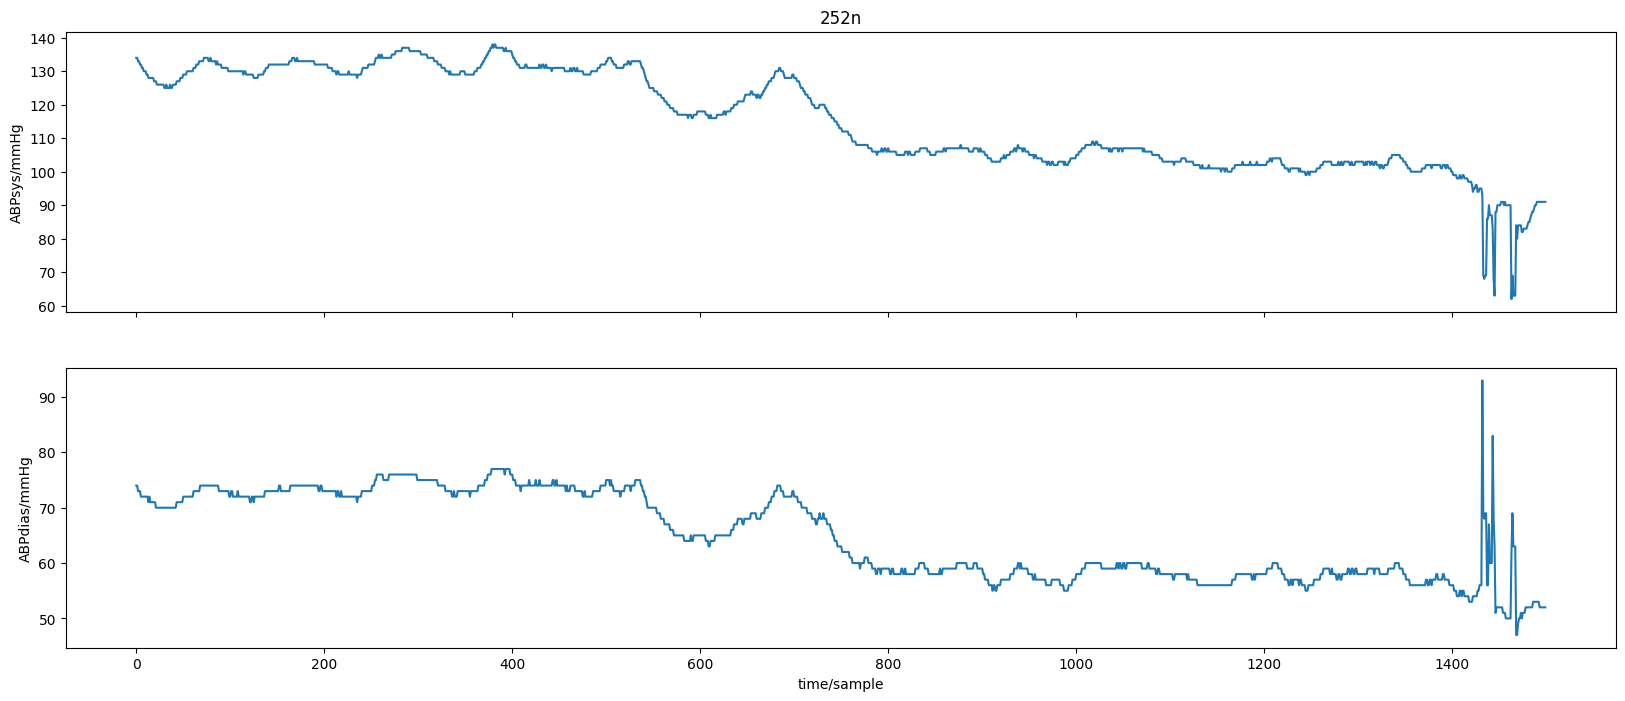

time: 182 ms (started: 2022-12-24 13:06:20 +00:00)


In [206]:
record_252n_abp = wfdb.rdrecord(numerics_folder/"252n", channels=[1,2], sampfrom=8000, sampto=9500)
# display(record_252n_abp record_252n.__dict__)
wfdb.plot_items(signal=record_252n_abp.p_signal, sig_name=record_252n_abp.sig_name, sig_units=record_252n_abp.units, title=f'{record_252n_abp.record_name}', figsize=(20, 8), sharex=True)

/usr/local/lib/python3.8/dist-packages/wfdb/io/annotation.py:1357: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  contained_labels = label_map.loc[index_vals, :]
/usr/local/lib/python3.8/dist-packages/wfdb/io/annotation.py:1357: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  contained_labels = label_map.loc[index_vals, :]


99023

None

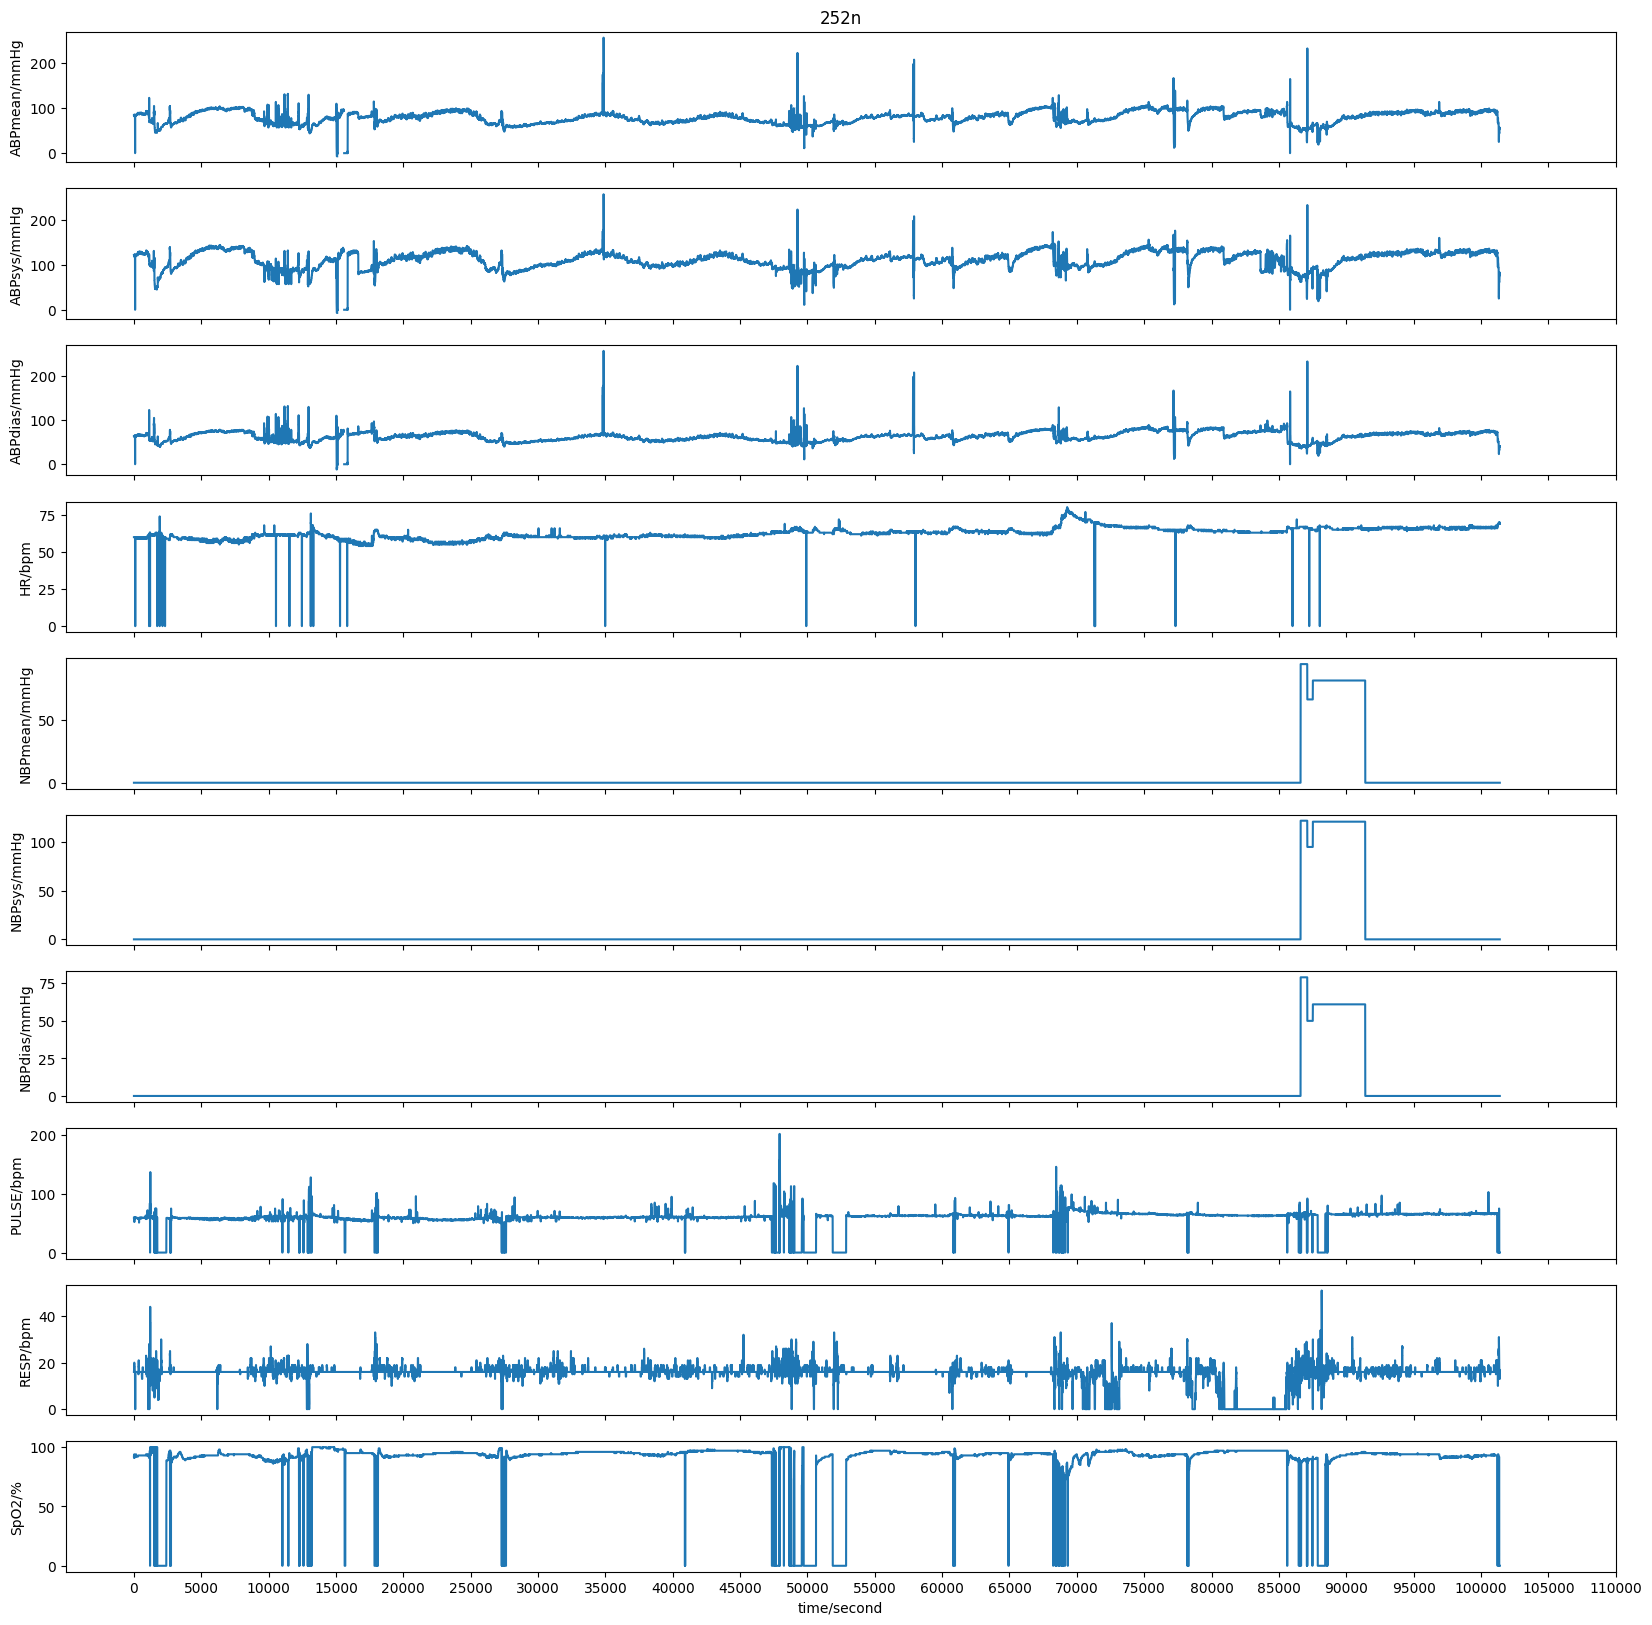

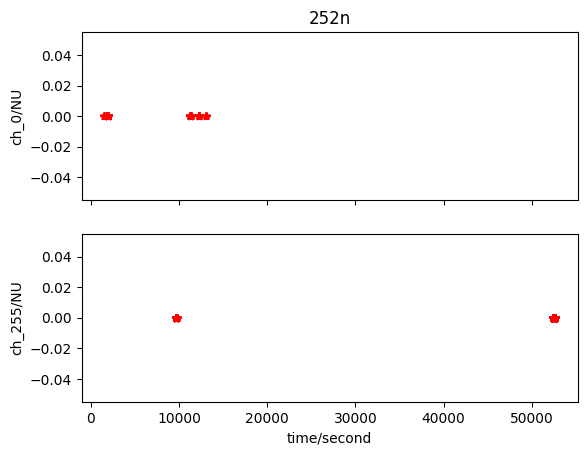

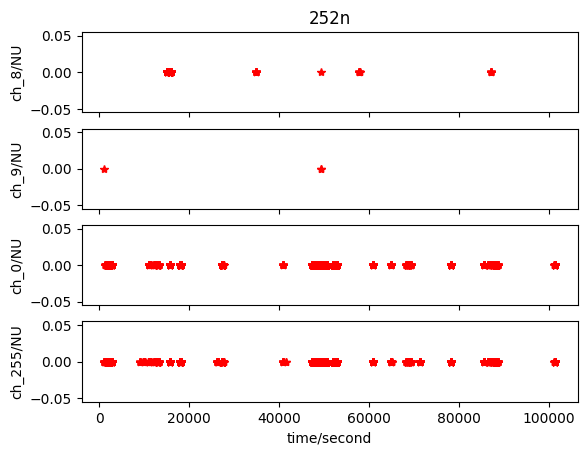

time: 1.35 s (started: 2022-12-23 16:35:34 +00:00)


In [67]:
numerics_folder = Path(raw_file_dir/"mimic-database-1.0.0"/"numerics")
record_252n = wfdb.rdrecord(numerics_folder/"252n")
ann_patient = wfdb.rdann(str(numerics_folder/"252n"), 'al', summarize_labels=True)  # al patient alarms
ann_monitor = wfdb.rdann(str(numerics_folder/"252n"), 'in', summarize_labels=True)  # in monitor status alarms
display(len(record_252n.p_signal))

record_252n_fig = wfdb.plot_wfdb(record=record_252n, title=f'{record_252n.record_name}', figsize=(20, 20), sharex=True, return_fig=True)
plt.xticks(range(0, 110001, 5000))
display(ann_patient.description)
# display(ann_patient.contained_labels)
# display(ann_patient.chan)
wfdb.plot_wfdb(annotation=ann_patient)
wfdb.plot_wfdb(annotation=ann_monitor)

# numpy.savetxt("252n.csv", record_252n.p_signal, delimiter=",")

## Observe correlation series record_252n_apb

array([1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443,
       1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454,
       1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465,
       1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476,
       1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487,
       1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498,
       1499])

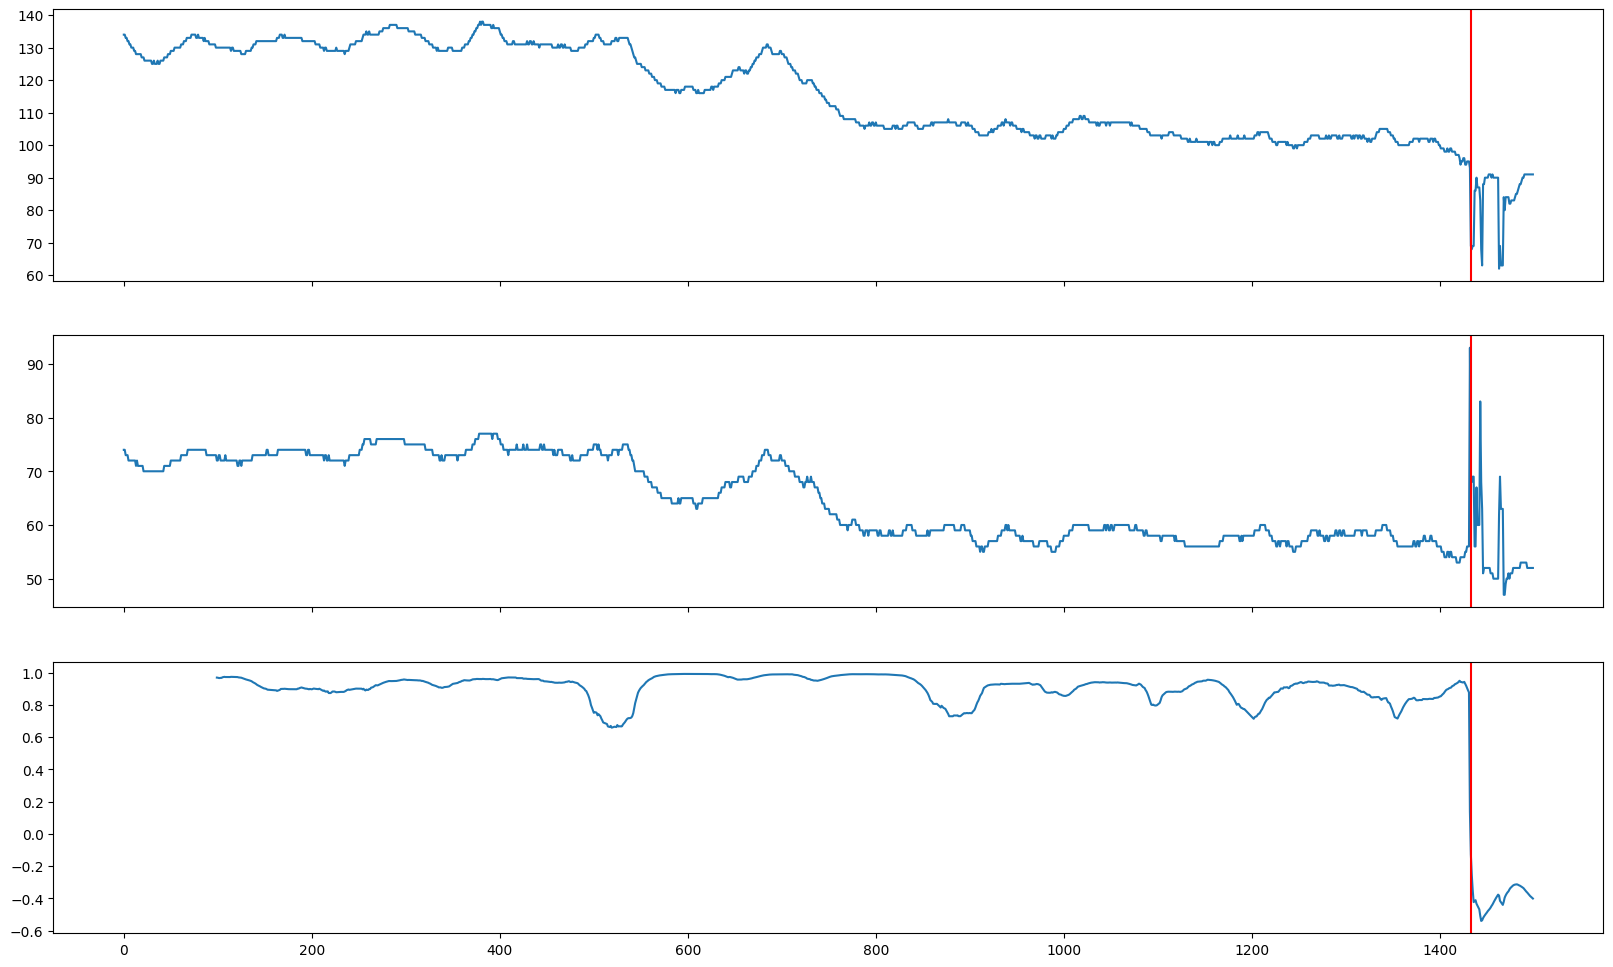

time: 292 ms (started: 2022-12-24 13:20:24 +00:00)


In [210]:
# wfdb_fig, wfdb_axes = wfdb.plot_items(signal=record_252n.p_signal, sig_name=record_252n.sig_name, sig_units=record_252n.units, figsize=(20, 8), sharex=True, return_fig_axes=True)  # return matplotlib axes
record_252n_abp_corr_series = pd.DataFrame(record_252n_abp.p_signal).rolling(window=100).corr().iloc[pd.IndexSlice[1::2],0].to_numpy()
fig1, ax = plt.subplots(3, 1, figsize=(20,12), sharex=True)
ax[0].plot(record_252n_abp.p_signal[:,0])
ax[0].axvline(x = 1433, color = 'r', label = 'correlation change')
# ax[0].axvline(x = 1564, color = 'r', label = 'correlation change')
ax[1].plot(record_252n_abp.p_signal[:,1])
ax[1].axvline(x = 1433, color = 'r', label = 'correlation change')
# ax[1].axvline(x = 1564, color = 'r', label = 'correlation change')
ax[2].plot(record_252n_abp_corr_series)
ax[2].axvline(x = 1433, color = 'r', label = 'correlation change')
# ax[2].axvline(x = 1564, color = 'r', label = 'correlation change')

pd.DataFrame(record_252n.p_signal, columns=["ABPsys/mmHg", "ABBPdias/mmHg"]).to_csv("../../tmp/252n.csv")
pd.DataFrame(record_252n_abp_corr_series, columns=["Pearson corr"]).to_csv("../../tmp/252n_abp_corr.csv")